In [1]:
from IPython.display import clear_output

!pip install openmim
!mim install mmdet
clear_output()

In [2]:
import mmcv
import mmdet
from mmcv import Config
from mmdet.apis import (
    inference_detector,
    init_detector,
    set_random_seed,
    show_result_pyplot,
    train_detector,
)
from mmdet.datasets import build_dataset
from mmdet.models import build_detector

In [3]:
SEED = 37
set_random_seed(SEED, deterministic=False)

In [4]:
import argparse
import ast
import glob
import json
import os
import re
import shutil

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from IPython.core.interactiveshell import InteractiveShell
from PIL import Image
from sklearn.model_selection import GroupKFold, StratifiedKFold
from tqdm import tqdm

InteractiveShell.ast_node_interactivity = "all"
import seaborn as sns
import torch
import torchvision

In [5]:
def plot_bboxes(img, bboxes, bbox_format="coco"):
    try:
        img_h, img_w = img.shape[:2]
    except:
        img_w, img_h = img.size
    fig, ax = plt.subplots(1, 1, figsize=(20, 12))
    ax.imshow(img)
    if bbox_format == "coco":
        for i in range(len(bboxes)):
            if len(bboxes[i].split()) == 5:
                bbox = bboxes[i].split()[1:]
            else:
                bbox = bboxes[i].split()
            x_center, y_center, width, height = list(map(float, bbox))
            x_min = int((x_center - width / 2) * img_w)
            y_min = int((y_center - height / 2) * img_h)
            width = int(width * img_w)
            height = int(height * img_h)
            rect = plt.Rectangle(
                [x_min, y_min], width, height, ec="r", fc="none", lw=2.0
            )
            ax.add_patch(rect)
    elif bbox_format == "from_df":
        for i in range(len(bboxes)):
            x_min, y_min, width, height = (
                bboxes[i]["x"],
                bboxes[i]["y"],
                bboxes[i]["width"],
                bboxes[i]["height"],
            )
            rect = plt.Rectangle(
                [x_min, y_min], width, height, ec="r", fc="none", lw=2.0
            )
            ax.add_patch(rect)
    plt.show();

In [6]:
TRAIN_DF_PART = "/app/_data/tensorflow-great-barrier-reef/train.csv"
SAMPLE_SUBMISSION_PATH = (
    "/app/_data/tensorflow-great-barrier-reef/example_sample_submission.csv"
)
TEST_DF_PATH = "/app/_data/tensorflow-great-barrier-reef/test.csv"
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
DEVICE

'cuda'

In [7]:
df = pd.read_csv(TRAIN_DF_PART)
df["img_path"] = (
    "/app/_data/tensorflow-great-barrier-reef/train_images/video_"
    + df.video_id.astype("str")
    + "/"
    + df.video_frame.astype("str")
    + ".jpg"
)
df["annotations"] = df["annotations"].apply(lambda x: ast.literal_eval(x))
df["len_annotation"] = df["annotations"].str.len()
df["image_id"] = df["image_id"].str.replace("-", "_", regex=True)
df["new_img_path"] = f"/app/_data/images/" + df["image_id"] + ".jpg"
train_df = pd.concat(
    [
        df.query("len_annotation!=0"),
        df.query("len_annotation==0").sample(
            6000 - len(df.query("len_annotation!=0")), random_state=SEED
        ),
    ],
    ignore_index=True,
)
train_df = train_df.sort_values(["video_id", "video_frame"]).reset_index(drop=True)

In [8]:
# for ix in df.index.tolist():
#     img_path = df.loc[ix, 'img_path']
#     img_name = df.loc[ix, 'image_id']
#     new_path = f'/app/_data/images/{img_name}.jpg'
#     shutil.copy(img_path, new_path,)
# clear_output()

In [9]:
len(glob.glob("/app/_data/images/*.jpg")) == len(df)

True

In [10]:
%%writefile /app/_data/for_mmdet/labels.txt
fish

Overwriting /app/_data/for_mmdet/labels.txt


In [11]:
def df_to_coco(df):
    images = []
    annotations = []
    img_id = 0
    annotation_id = 0
    categories = [
        {
            "id": 0,
            "name": "fish",
        },
    ]
    df = df.reset_index(drop=True)
    for ix in tqdm(df.index.tolist()):
        img = Image.open(df.loc[ix, "img_path"])
        w, h = img.size
        bboxes = df.loc[ix, "annotations"]
        img_name = f'{df.loc[ix, "image_id"]}.jpg'
        img_dict = {
            "id": img_id,
            "file_name": img_name,
            "height": h,
            "width": w,
        }
        images.append(img_dict)
        if len(bboxes) != 0:
            for i in range(len(bboxes)):
                bbox = bboxes[i]
                bbox = [bbox["x"], bbox["y"], bbox["width"], bbox["height"]]
                annotations_dict = {
                    "id": annotation_id,
                    "image_id": img_id,
                    "category_id": 0,
                    "bbox": bbox,
                    "area": bbox[2] * bbox[3],
                    "segmentation": [],
                    "iscrowd": 0,
                }
                annotations.append(annotations_dict)
                annotation_id += 1
        img_id += 1
    coco_dict = {"categories": categories, "images": images, "annotations": annotations}
    return coco_dict

## KFold split

In [12]:
KFOLD = 1

In [13]:
kf = GroupKFold(n_splits=5)
list_train_ids = []
list_val_ids = []
for train_idx, val_idx in kf.split(
    train_df, y=train_df.len_annotation, groups=train_df.sequence
):
    list_train_ids.append(train_idx)
    list_val_ids.append(val_idx)
    print(
        train_df.loc[val_idx, "len_annotation"].values.sum(),
        train_df.loc[train_idx, "len_annotation"].values.sum(),
    )

3195 8703
2976 8922
1455 10443
1442 10456
2830 9068


In [14]:
train_dict = df_to_coco(train_df.loc[list_train_ids[KFOLD]])
with open("/app/_data/for_mmdet/coco_train.json", "w") as f:
    json.dump(train_dict, f, ensure_ascii=True, indent=4)
val_dict = df_to_coco(train_df.loc[list_val_ids[KFOLD]])
with open("/app/_data/for_mmdet/coco_val.json", "w") as f:
    json.dump(val_dict, f, ensure_ascii=True, indent=4)

100% 4812/4812 [00:00<00:00, 6369.05it/s]
100% 1188/1188 [00:00<00:00, 4604.47it/s]


# Model Config

In [15]:
%%writefile /app/_data/mmdetection/configs/swin/TFGBR_swin_base_faster_rcnn_fp16_test.py

_base_ = [
    "/app/_data/mmdetection/configs/_base_/models/faster_rcnn_r50_fpn.py",
    "/app/_data/mmdetection/configs/_base_/datasets/coco_detection.py",
    "/app/_data/mmdetection/configs/_base_/schedules/schedule_2x.py",
    "/app/_data/mmdetection/configs/_base_/default_runtime.py",
]
pretrained = 'https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_small_patch4_window7_224.pth'
model = dict(
    backbone=dict(
        _delete_=True,
        type='SwinTransformer',
        embed_dims=96,
        depths=[2, 2, 18, 2],
        num_heads=[3, 6, 12, 24],
        window_size=7,
        mlp_ratio=4,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.,
        attn_drop_rate=0.,
        drop_path_rate=0.2,
        patch_norm=True,
        out_indices=(0, 1, 2, 3),
        with_cp=False,
        convert_weights=True,
        init_cfg=dict(type='Pretrained', checkpoint=pretrained)),
    neck=dict(in_channels=[96, 192, 384, 768]),
    roi_head=dict(
        type='CascadeRoIHead',
        num_stages=3,
        stage_loss_weights=[1, 0.5, 0.25],
        bbox_roi_extractor=dict(
            type='SingleRoIExtractor',
            roi_layer=dict(type='RoIAlign', output_size=7, sampling_ratio=0),
            out_channels=256,
            featmap_strides=[4, 8, 16, 32]),
        bbox_head=[
            dict(
                type='Shared2FCBBoxHead',
                in_channels=256,
                fc_out_channels=1024,
                roi_feat_size=7,
                num_classes=1,
                bbox_coder=dict(
                    type='DeltaXYWHBBoxCoder',
                    target_means=[0., 0., 0., 0.],
                    target_stds=[0.1, 0.1, 0.2, 0.2]),
                reg_class_agnostic=True,
                loss_cls=dict(
                    type='CrossEntropyLoss',
                    use_sigmoid=False,
                    loss_weight=1.0),
                reg_decoded_bbox=True,
                loss_bbox=dict(type='GIoULoss', loss_weight=10.0)),
            dict(
                type='Shared2FCBBoxHead',
                in_channels=256,
                fc_out_channels=1024,
                roi_feat_size=7,
                num_classes=1,
                bbox_coder=dict(
                    type='DeltaXYWHBBoxCoder',
                    target_means=[0., 0., 0., 0.],
                    target_stds=[0.05, 0.05, 0.1, 0.1]),
                reg_class_agnostic=True,
                loss_cls=dict(
                    type='CrossEntropyLoss',
                    use_sigmoid=False,
                    loss_weight=1.0),
                reg_decoded_bbox=True,
                loss_bbox=dict(type='GIoULoss', loss_weight=10.0)),
            dict(
                type='Shared2FCBBoxHead',
                in_channels=256,
                fc_out_channels=1024,
                roi_feat_size=7,
                num_classes=1,
                bbox_coder=dict(
                    type='DeltaXYWHBBoxCoder',
                    target_means=[0., 0., 0., 0.],
                    target_stds=[0.033, 0.033, 0.067, 0.067]),
                reg_class_agnostic=True,
                loss_cls=dict(
                    type='CrossEntropyLoss',
                    use_sigmoid=False,
                    loss_weight=1.0),
                reg_decoded_bbox=True,
                loss_bbox=dict(type='GIoULoss', loss_weight=10.0))
        ]))

optimizer = dict(
    _delete_=True,
    type='AdamW',
    lr=0.0005,
    betas=(0.9, 0.999),
    weight_decay=0.05,
    paramwise_cfg=dict(
        custom_keys={
            'absolute_pos_embed': dict(decay_mult=0.),
            'relative_position_bias_table': dict(decay_mult=0.),
            'norm': dict(decay_mult=0.)
        }))
lr_config = dict(warmup_iters=500, step=[8, 11])
runner = dict(max_epochs=12)

Overwriting /app/_data/mmdetection/configs/swin/TFGBR_swin_base_faster_rcnn_fp16_test.py


In [16]:
cfg = Config.fromfile(
    "/app/_data/mmdetection/configs/swin/TFGBR_swin_base_faster_rcnn_fp16_test.py"
)

In [17]:
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True
)
train_pipeline = [
    dict(type="LoadImageFromFile", to_float32=True),
    dict(type="LoadAnnotations", with_bbox=True),
    dict(
        type="AutoAugment",
        policies=[
            [
                dict(
                    type="Resize",
                    img_scale=[
                        (480, 1333),
                        (512, 1333),
                        (544, 1333),
                        (576, 1333),
                        (608, 1333),
                        (640, 1333),
                        (672, 1333),
                        (704, 1333),
                        (736, 1333),
                        (768, 1333),
                        (800, 1333),
                    ],
                    multiscale_mode="value",
                    keep_ratio=True,
                )
            ],
            [
                dict(
                    type="Resize",
                    img_scale=[(400, 1333), (500, 1333), (600, 1333)],
                    multiscale_mode="value",
                    keep_ratio=True,
                ),
                dict(
                    type="RandomCrop",
                    crop_type="absolute_range",
                    crop_size=(384, 600),
                    allow_negative_crop=True,
                ),
                dict(
                    type="Resize",
                    img_scale=[
                        (480, 1333),
                        (512, 1333),
                        (544, 1333),
                        (576, 1333),
                        (608, 1333),
                        (640, 1333),
                        (672, 1333),
                        (704, 1333),
                        (736, 1333),
                        (768, 1333),
                        (800, 1333),
                    ],
                    multiscale_mode="value",
                    override=True,
                    keep_ratio=True,
                ),
                dict(
                    type="PhotoMetricDistortion",
                    brightness_delta=32,
                    contrast_range=(0.5, 1.5),
                    saturation_range=(0.5, 1.5),
                    hue_delta=18,
                ),
                dict(
                    type="MinIoURandomCrop",
                    min_ious=(0.4, 0.5, 0.6, 0.7, 0.8, 0.9),
                    min_crop_size=0.3,
                ),
                dict(
                    type="CutOut",
                    n_holes=(5, 10),
                    cutout_shape=[
                        (4, 4),
                        (4, 8),
                        (8, 4),
                        (8, 8),
                        (16, 32),
                        (32, 16),
                        (32, 32),
                        (32, 48),
                        (48, 32),
                        (48, 48),
                    ],
                ),
            ],
        ],
    ),
    dict(type="RandomFlip", flip_ratio=0.5),
    dict(type="Normalize", **img_norm_cfg),
    dict(type="Pad", size_divisor=32),
    dict(type="DefaultFormatBundle"),
    dict(type="Collect", keys=["img", "gt_bboxes", "gt_labels"]),
]

test_pipeline = [
    dict(type="LoadImageFromFile"),
    dict(
        type="MultiScaleFlipAug",
        img_scale=(1333, 800),
        flip=False,
        transforms=[
            dict(type="Resize", keep_ratio=True),
            dict(type="RandomFlip"),
            dict(type="Normalize", **img_norm_cfg),
            dict(type="Pad", size_divisor=32),
            dict(type="DefaultFormatBundle"),
            dict(type="Collect", keys=["img"]),
        ],
    ),
]

In [41]:
cfg.classes = "/app/_data/for_mmdet/labels.txt"
cfg.work_dir = f"/app/_data/model_output_{KFOLD+1}"
cfg.data_root = "/app/_data/for_mmdet"

# cfg.model.roi_head.bbox_head.num_classes = 1

cfg.data.test.type = "CocoDataset"
cfg.data.test.classes = "/app/_data/for_mmdet/labels.txt"
cfg.data.test.ann_file = "/app/_data/for_mmdet/coco_val.json"
cfg.data.test.img_prefix = ""
cfg.data.test.data_root = "/app/_data/for_mmdet"

cfg.data.train.type = "CocoDataset"
cfg.data.train.ann_file = "/app/_data/for_mmdet/coco_train.json"
cfg.data.train.img_prefix = ""
cfg.data.train.classes = "/app/_data/for_mmdet/labels.txt"
cfg.data.val.data_root = "/app/_data/for_mmdet"

cfg.data.val.type = "CocoDataset"
cfg.data.val.ann_file = "/app/_data/for_mmdet/coco_val.json"
cfg.data.val.img_prefix = ""
cfg.data.val.classes = "/app/_data/for_mmdet/labels.txt"
cfg.data.val.data_root = "/app/_data/for_mmdet"

cfg.data.samples_per_gpu = 4
cfg.data.workers_per_gpu = 4

cfg.train_pipeline = train_pipeline
cfg.val_pipeline = test_pipeline
cfg.test_pipeline = test_pipeline

cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.val.pipeline = cfg.val_pipeline


cfg.runner.max_epochs = 30
cfg.evaluation.save_best = "auto"

cfg.seed = SEED
cfg.gpu_ids = range(1)
cfg.fp16 = dict(loss_scale=512.0)
meta = dict()
meta["config"] = cfg.pretty_text

AttributeError: 'list' object has no attribute 'num_classes'

# Inference

In [19]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append(
            "{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3])
        )

    return " ".join(pred_strings)

In [20]:
model = init_detector(
    cfg, "/app/_data/mmdetection/model_output1/best_bbox_mAP_epoch_10.pth"
)

load checkpoint from local path: /app/_data/mmdetection/model_output1/best_bbox_mAP_epoch_10.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: roi_head.bbox_head.fc_cls.weight, roi_head.bbox_head.fc_cls.bias, roi_head.bbox_head.fc_reg.weight, roi_head.bbox_head.fc_reg.bias, roi_head.bbox_head.shared_fcs.0.weight, roi_head.bbox_head.shared_fcs.0.bias, roi_head.bbox_head.shared_fcs.1.weight, roi_head.bbox_head.shared_fcs.1.bias

missing keys in source state_dict: roi_head.bbox_head.0.fc_cls.weight, roi_head.bbox_head.0.fc_cls.bias, roi_head.bbox_head.0.fc_reg.weight, roi_head.bbox_head.0.fc_reg.bias, roi_head.bbox_head.0.shared_fcs.0.weight, roi_head.bbox_head.0.shared_fcs.0.bias, roi_head.bbox_head.0.shared_fcs.1.weight, roi_head.bbox_head.0.shared_fcs.1.bias, roi_head.bbox_head.1.fc_cls.weight, roi_head.bbox_head.1.fc_cls.bias, roi_head.bbox_head.1.fc_reg.weight, roi_head.bbox_head.1.fc_reg.bias, roi_head.bbox_head.1.shared_fcs.0.weight, roi

In [55]:
df

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,img_path,len_annotation,new_img_path
0,0,40258,0,0,0_0,[],/app/_data/tensorflow-great-barrier-reef/train...,0,/app/_data/images/0_0.jpg
1,0,40258,1,1,0_1,[],/app/_data/tensorflow-great-barrier-reef/train...,0,/app/_data/images/0_1.jpg
2,0,40258,2,2,0_2,[],/app/_data/tensorflow-great-barrier-reef/train...,0,/app/_data/images/0_2.jpg
3,0,40258,3,3,0_3,[],/app/_data/tensorflow-great-barrier-reef/train...,0,/app/_data/images/0_3.jpg
4,0,40258,4,4,0_4,[],/app/_data/tensorflow-great-barrier-reef/train...,0,/app/_data/images/0_4.jpg
...,...,...,...,...,...,...,...,...,...
23496,2,29859,10755,2983,2_10755,[],/app/_data/tensorflow-great-barrier-reef/train...,0,/app/_data/images/2_10755.jpg
23497,2,29859,10756,2984,2_10756,[],/app/_data/tensorflow-great-barrier-reef/train...,0,/app/_data/images/2_10756.jpg
23498,2,29859,10757,2985,2_10757,[],/app/_data/tensorflow-great-barrier-reef/train...,0,/app/_data/images/2_10757.jpg
23499,2,29859,10758,2986,2_10758,[],/app/_data/tensorflow-great-barrier-reef/train...,0,/app/_data/images/2_10758.jpg


In [21]:
# img = np.load("/app/_data/SYOLOv4/1.npy")
img = cv2.imread(df[df['len_annotation']>5].sample()['img_path'].values[0])

In [22]:
# img[:, :, ::-1].shape

In [23]:
# plt.imshow(img[:, :, ::-1])

In [36]:
result = inference_detector(model, img[:, :, ::-1])

In [37]:
len(result)

1

In [38]:
result[0][:,4]

array([0.6632294 , 0.6483169 , 0.6434998 , 0.6406073 , 0.6363997 ,
       0.63226336, 0.6290368 , 0.6288466 , 0.6270589 , 0.6249074 ,
       0.62456393, 0.6236345 , 0.62184393, 0.62047094, 0.61962783,
       0.61862534, 0.6185112 , 0.61847895, 0.6182852 , 0.61771643,
       0.6175673 , 0.6169384 , 0.6163074 , 0.6148367 , 0.61407506,
       0.6140057 , 0.6135556 , 0.6131397 , 0.6123489 , 0.61010826,
       0.6099609 , 0.6098269 , 0.6095359 , 0.6092176 , 0.60917985,
       0.60867375, 0.60845685, 0.6080508 , 0.60766435, 0.6074424 ,
       0.6074401 , 0.60693574, 0.6058847 , 0.6053588 , 0.60499597,
       0.6049623 , 0.60481197, 0.60465425, 0.60451186, 0.6044044 ,
       0.60393906, 0.60361147, 0.60345954, 0.6034375 , 0.60336584,
       0.6028084 , 0.60138553, 0.6011165 , 0.6010716 , 0.6007712 ,
       0.6003821 , 0.599807  , 0.5997911 , 0.5996358 , 0.5994632 ,
       0.5993735 , 0.59866184, 0.5985646 , 0.5982148 , 0.5980475 ,
       0.59734154, 0.59722847, 0.5970321 , 0.59684443, 0.59669

In [39]:
bboxes = []
for i in result:
    if i.size != 0:
        for j in i:
            bboxes.append(j)
bboxes = np.array(bboxes)

In [40]:
bboxes[:,4]>0.3

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [46]:
def show_result_pyplot(model,
                       img,
                       result,
                       score_thr=0.3,
                       title='result',
                       wait_time=0):

    if hasattr(model, 'module'):
        model = model.module
    model.show_result(
        img,
        result,
        score_thr=score_thr,
        show=True,
        wait_time=wait_time,
        win_name=title,
        bbox_color=(72, 101, 241),
        text_color=(72, 101, 241))

In [48]:
if isinstance(result, tuple):
    bbox_result, segm_result = result
    if isinstance(segm_result, tuple):
        segm_result = segm_result[0]  # ms rcnn
else:
    bbox_result, segm_result = result, None

In [49]:
segm_result

In [51]:
bboxes = np.vstack(bbox_result)
# bboxes

In [52]:
labels = [
            np.full(bbox.shape[0], i, dtype=np.int32)
            for i, bbox in enumerate(bbox_result)
        ]
labels = np.concatenate(labels)

In [53]:
labels

array([18, 18, 21, 25, 28, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 44,
       44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 52, 52, 52, 69],
      dtype=int32)

IndexError: list index out of range

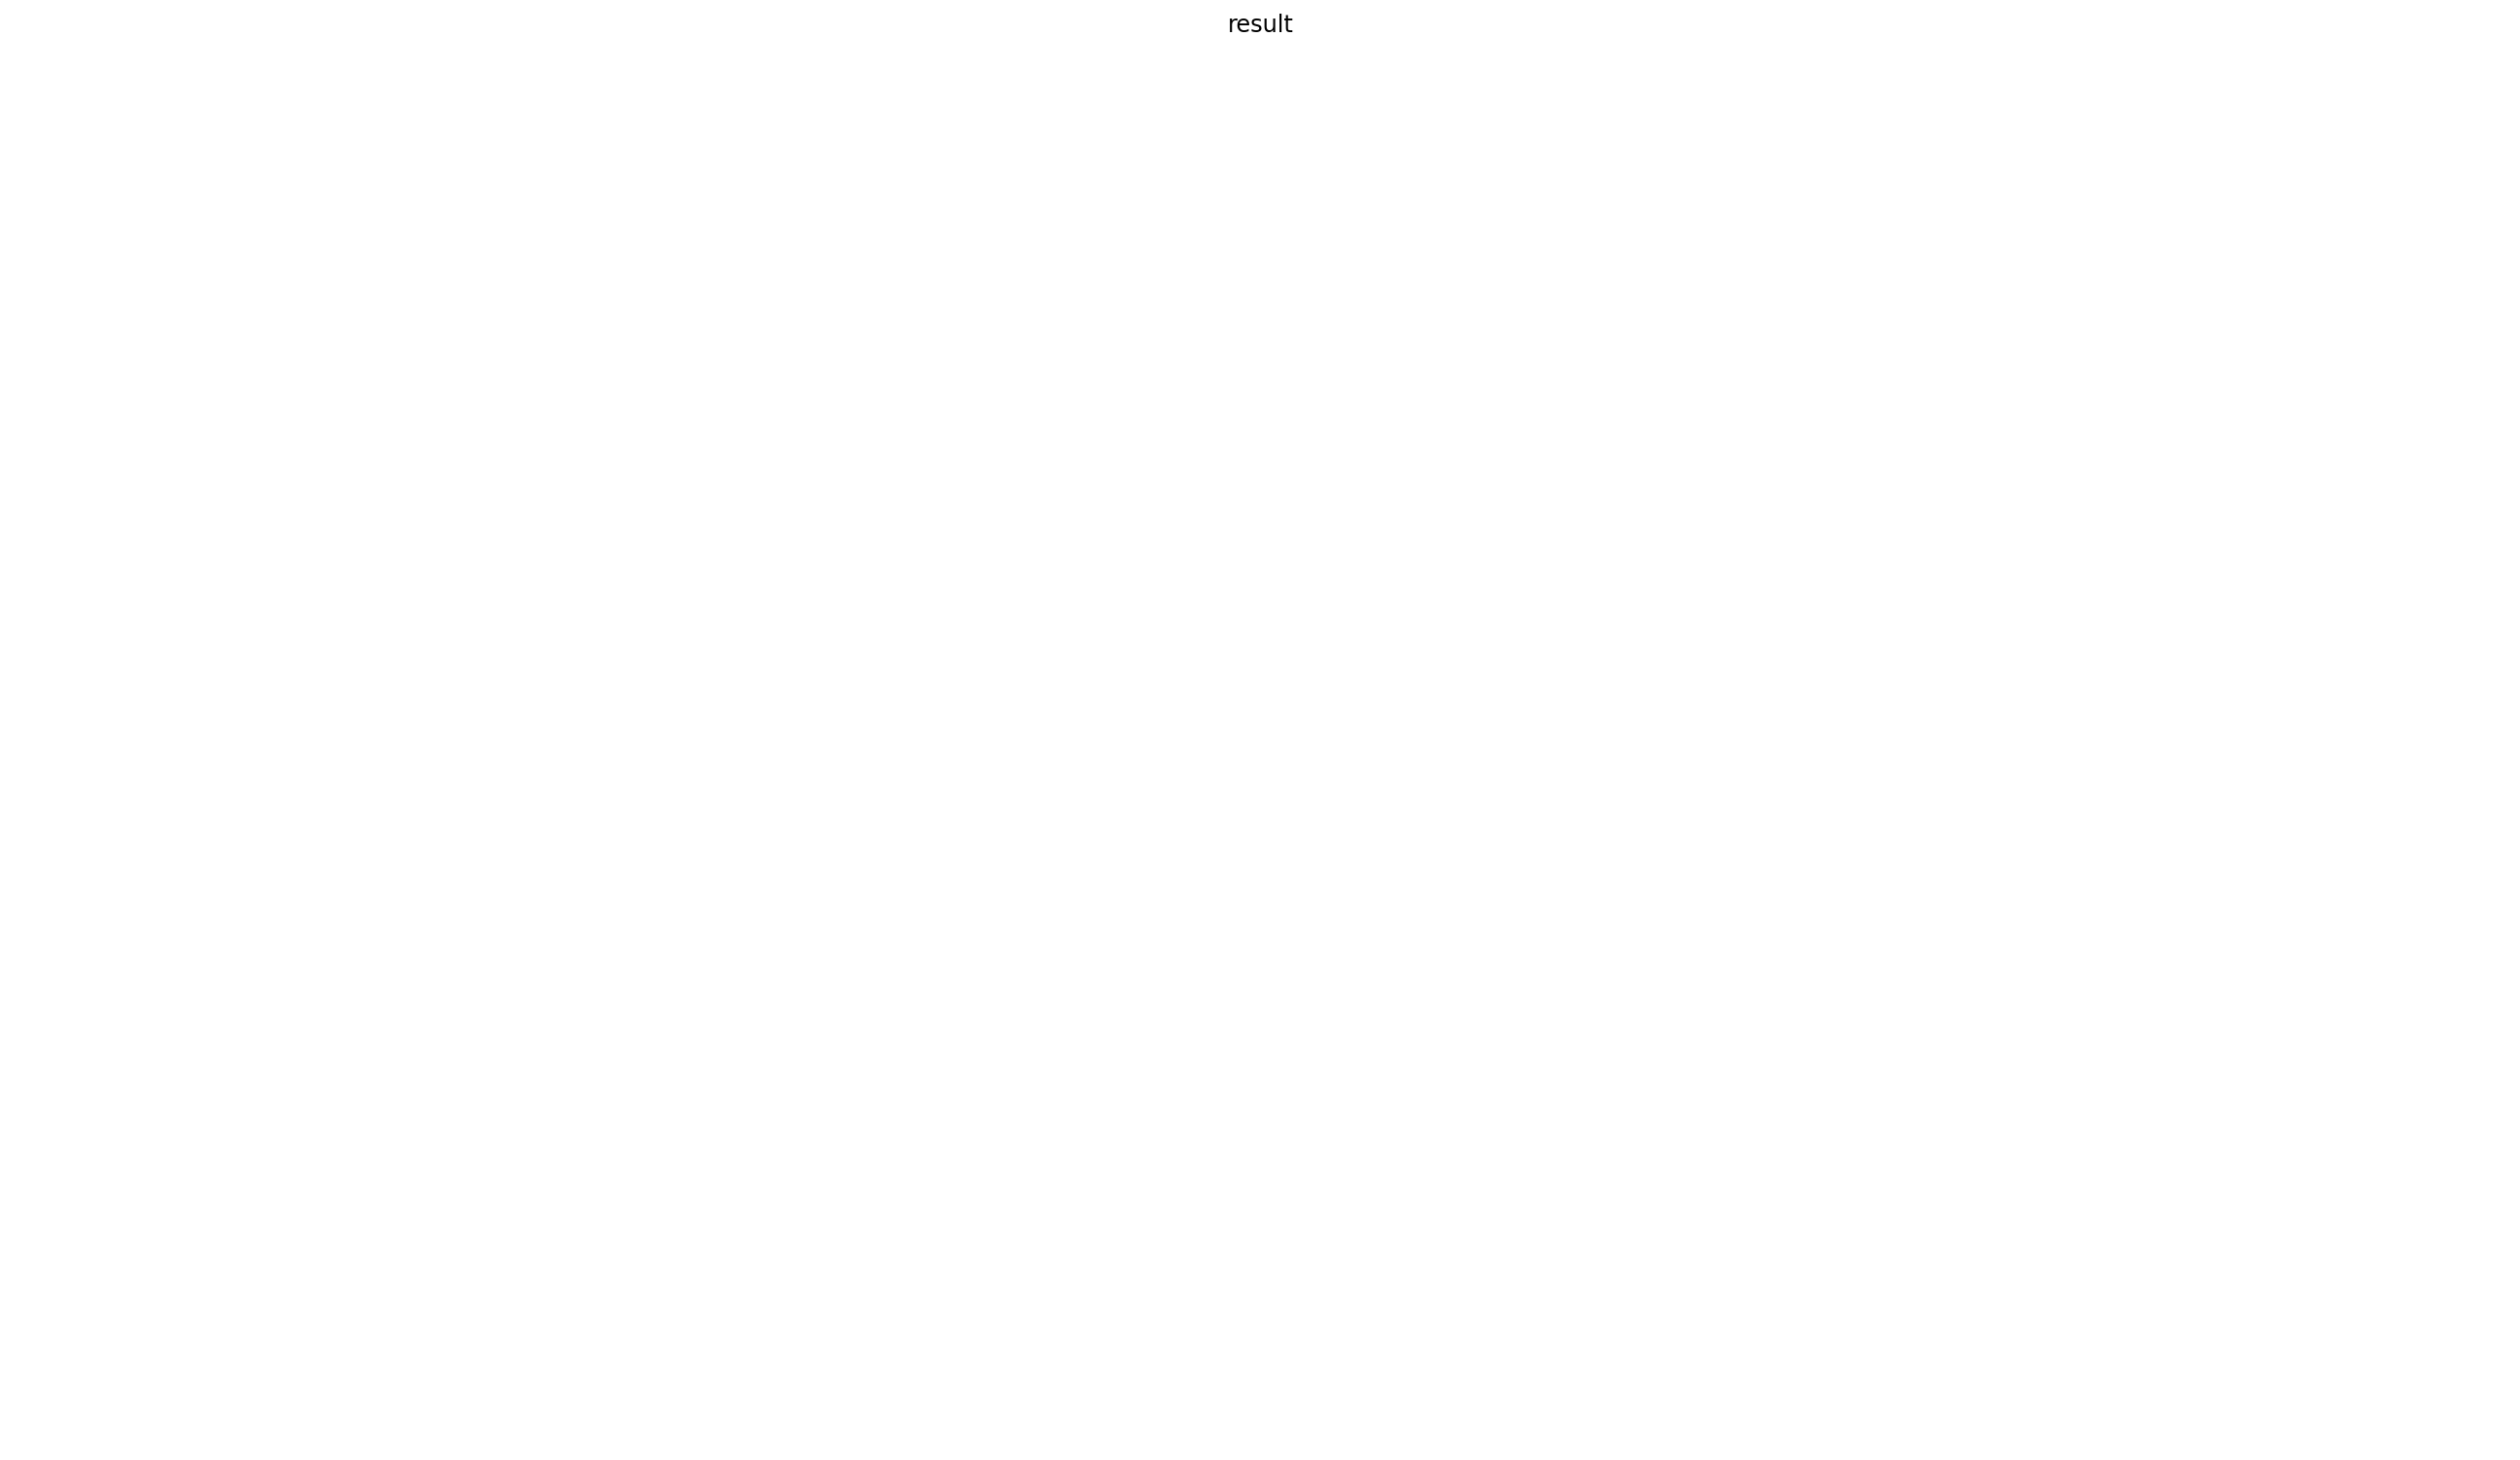

In [47]:
show_result_pyplot(model,
                       img[:, :, ::-1],
                       result,
                       score_thr=0.3,
                       title='result',
                       wait_time=0)

In [ ]:
boxes = result[0][:, :4]
scores = result[0][:, 4]